In [1]:
import os

num_chains = 10
n_devices = min(os.cpu_count(), num_chains)
os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={n_devices}'

from typing import Tuple, Dict, Any

import pandas as pd
import numpy as np

import jax.numpy as jnp

from scipy.stats import norm

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

import matplotlib.pyplot as plt
import seaborn as sns

from namgcv.basemodels.bnam import BayesianNAM
from namgcv.configs.bayesian_nam_config import DefaultBayesianNAMConfig
from namgcv.configs.bayesian_nn_config import DefaultBayesianNNConfig

import pickle

2025-03-10 08:38:14,853 - jax._src.xla_bridge - INFO - Unable to initialize backend 'cuda': 
2025-03-10 08:38:14,853 - jax._src.xla_bridge - INFO - Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2025-03-10 08:38:14,853 - jax._src.xla_bridge - INFO - Unable to initialize backend 'tpu': UNIMPLEMENTED: LoadPjrtPlugin is not implemented on windows yet.
2025-03-10 08:38:15,398 - datasets - INFO - PyTorch version 2.6.0 available.
2025-03-10 08:38:15,398 - datasets - INFO - JAX version 0.4.28 available.


In [2]:
GREEN_RGB_COLORS = [
    '#004c00',  # '#004e00', '#005000', '#005100', '#005300',
    # '#005500', # '#005700', '#005900', '#005a00', '#005c00',
    '#005e00',  # '#006000', '#006200', '#006300', '#006500',
    # '#006700', # '#006900', '#006b00', '#006c00', '#006e00',
    '#007000',  # '#007200', '#007400', '#007500', '#007700',
    # '#007900', # '#007b00', '#007d00', '#007e00', '#008000',
    '#008200',  # '#008400', '#008600', '#008800', '#008900',
    # '#008b00', # '#008d00', '#008f00', '#009100', '#009200',
    '#009400',  # '#009600', '#009800', '#009a00', '#009b00',
    # '#009d00', # '#009f00', '#00a100', '#00a300', '#00a400',
    '#00a600',  # '#00a800', '#00aa00', '#00ac00', '#00ad00',
    # '#00af00', # '#00b100', '#00b300', '#00b500', '#00b600',
    '#00b800',  # '#00ba00', '#00bc00', '#00be00', '#00bf00',
    # '#00c100', # '#00c300', '#00c500', '#00c700', '#00c800',
    '#00ca00',  # '#00cc00', '#00ce00', '#00d000', '#00d100',
    # '#00d300', # '#00d500', '#00d700', '#00d900', '#00da00',
    '#00dc00',  # '#00de00', '#00e000', '#00e200', '#00e300',
    # '#00e500', # '#00e700', '#00e900', '#00eb00', '#00ec00',
    '#00ee00',  # '#00f000', '#00f200', '#00f400', '#00f500',
    # '#00f700', # '#00f900', '#00fb00', '#00fd00', '#00ff00'
]

In [3]:
def plot_synthetic_data(
        true_effects: dict,
        response: jnp.ndarray,
):
    """
    Function to plot the synthetic data generated for testing the BayesianNAM model.

    Parameters
    ----------
    true_effects: dict containing the true effects of the features.
    response: jnp.ndarray containing the response variable.
    """

    sns.set_style("whitegrid", {"axes.facecolor": ".9"})

    # Target variable distribution.
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
    sns.distplot(
        response,
        hist=True,
        kde=True,
        bins=30,
        color=GREEN_RGB_COLORS[0],
        label="Target Variable",
        ax=ax
    )
    ax.legend()
    ax.set_title(
        label=f"Distribution of the Target Variable | "
              f"Mean: {response.mean():.2f}, "
              f"Std: {response.std():.2f}",
        fontsize=14
    )
    ax.set_xlabel("Response", fontsize=12)
    ax.set_ylabel("Density", fontsize=12)
    ax.grid(True)
    plt.tight_layout()
    plt.show()


    single_true_effects = {
        feature_name: feature_value for feature_name, feature_value in true_effects.items()
        if ":" not in feature_name
    }
    if single_true_effects:
        fig, axes = plt.subplots(
            nrows=len(single_true_effects),
            ncols=2,
            figsize=(12, 6 * len(single_true_effects))
        )
        for i, feature_name in enumerate(single_true_effects.keys()):
            x_vals = single_true_effects[feature_name]["feature"]
            y_mean = single_true_effects[feature_name]["response"]

            sort_idx = np.argsort(x_vals)
            x_sorted = x_vals[sort_idx]
            y_sorted = y_mean[sort_idx]

            # Plot noise intervals.
            if not isinstance(true_effects[feature_name]["noise_parameters"]["scale"], np.ndarray):
                true_effects[feature_name]["noise_parameters"]["scale"] = (
                        np.ones(len(x_sorted)) * true_effects[feature_name]["noise_parameters"]["scale"]
                )

            for ci_multiplier, alpha in zip([3, 2, 1], [0.2, 0.4, 0.8]):
                axes[i,0].fill_between(
                    x_sorted,
                    y_sorted - ci_multiplier
                        * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    y_sorted + ci_multiplier
                        * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    color=GREEN_RGB_COLORS[-1],
                    alpha=alpha
                )
                # Plot outlines for the filled areas.
                axes[i,0].plot(
                    x_sorted,
                    y_sorted - ci_multiplier
                        * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    color='black',
                    linestyle='dashed',
                    alpha=0.2
                )
                axes[i,0].plot(
                    x_sorted,
                    y_sorted + ci_multiplier
                        * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    color='black',
                    linestyle='dashed',
                    alpha=0.2
                )

            # Plot points.
            sns.scatterplot(
                x=single_true_effects[feature_name]["feature"][sort_idx],
                y=single_true_effects[feature_name]["response"][sort_idx]
                    + single_true_effects[feature_name]["noise"][sort_idx],
                color=GREEN_RGB_COLORS[5],
                label="Noisy Response",
                ax=axes[i,0]
            )
            # Plot mean.
            sns.lineplot(
                x=single_true_effects[feature_name]["feature"][sort_idx],
                y=single_true_effects[feature_name]["response"][sort_idx],
                color="black",
                label="True Mean Marginal Effect",
                ax=axes[i,0],
            )
            axes[i,0].set_title(f"{feature_name} Effect", fontsize=14)
            axes[i,0].set_xlabel(f"{feature_name}", fontsize=12)
            axes[i,0].set_ylabel("Effect", fontsize=12)
            axes[i,0].legend()
            axes[i,0].grid(True)

            # Plot noise intervals.
            axes[i, 1].axhline(0, color='black', label="True Noise Mean")
            for ci_multiplier, alpha in zip([3, 2, 1], [0.2, 0.4, 0.8]):
                axes[i, 1].fill_between(
                    x_sorted,
                    -ci_multiplier * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    ci_multiplier * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    color=GREEN_RGB_COLORS[-1],
                    alpha=alpha
                )
                # Plot outlines for the filled areas.
                axes[i, 1].plot(
                    x_sorted,
                    -ci_multiplier * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    color='black',
                    linestyle='dashed',
                    alpha=0.2
                )
                axes[i, 1].plot(
                    x_sorted,
                    ci_multiplier * true_effects[feature_name]["noise_parameters"]["scale"][sort_idx],
                    color='black',
                    linestyle='dashed',
                    alpha=0.2
                )

            # Plot points.
            sns.scatterplot(
                x=single_true_effects[feature_name]["feature"][sort_idx],
                y=single_true_effects[feature_name]["noise"][sort_idx],
                color=GREEN_RGB_COLORS[5],
                label="Sampled Noise",
                ax=axes[i,1]
            )

            axes[i,1].set_title(f"{feature_name} Noise Effect", fontsize=14)
            axes[i,1].set_xlabel(f"{feature_name}", fontsize=12)
            axes[i,1].set_ylabel("Effect", fontsize=12)
            axes[i,1].legend()
            axes[i,1].grid(True)

        plt.legend()
        plt.tight_layout()
        plt.show()

In [4]:
def get_synthetic_data(n_samples: int=500):
    """
    Function to generate synthetic data for testing the BayesianNAM model.
    Returns a pandas DataFrame containing the synthetic data.

    Args:
        n_samples (int): Number of samples to generate.

    Returns:
        pd.DataFrame: DataFrame containing the synthetic data.
    """

    # ------------------
    # Generate features.
    # ------------------
    np.random.seed(42)

    numerical_1 = np.random.uniform(low=-1, high=1, size=n_samples)
    numerical_2 = np.random.uniform(low=-1, high=1, size=n_samples)
    # numerical_3 = np.random.uniform(low=-1, high=1, size=n_samples)
    # numerical_4 = np.random.uniform(low=-1, high=1, size=n_samples)

    # categorical_1 = np.random.choice(a=['A', 'B', 'C'], size=n_samples)
    # categorical_2 = np.random.choice(a=['X', 'Y', 'Z'], size=n_samples)
    # encoder = OneHotEncoder()
    # cat_1_encoded = pd.DataFrame(
    #     encoder.fit_transform(categorical_1.reshape(-1, 1)).toarray(),
    #     columns=[f"Cat1_{cat}" for cat in encoder.categories_[0]]
    # )
    # cat_2_encoded = pd.DataFrame(
    #     encoder.fit_transform(categorical_2.reshape(-1, 1)).toarray(),
    #     columns=[f"Cat2_{cat}" for cat in encoder.categories_[0]]
    # )

    # Make the noise parameters dependent on the true effects.
    noise_parameters = {
        "numerical_1": {"loc": 0, "scale": 0.1+np.square(numerical_1)/100, "size": n_samples},
        "numerical_2": {"loc": 0, "scale": 0.1+np.square(numerical_2)/100,  "size": n_samples},
        # "numerical_3": {"loc": 0, "scale": 0.1+np.square(numerical_3)/100, "size": n_samples},
        # "numerical_4": {"loc": 0, "scale": 0.1+np.square(numerical_4)/100, "size": n_samples},
        # "numerical_1": {"loc": 0, "scale": 0.1*np.abs(5), "size": n_samples},
        # "numerical_2": {"loc": 0, "scale": 0.1*np.abs(5), "size": n_samples},
        # "numerical_3": {"loc": 0, "scale": 0.1*np.abs(5), "size": n_samples},
        # "numerical_4": {"loc": 0, "scale": 0.1*np.abs(5), "size": n_samples},
        # "categorical_1": {"a": [-1, 0, 1], "p": [0.1, 0.8, 0.1], "size": n_samples},
        # "categorical_2": {"a": [-1, 0, 1], "p": [0.1, 0.8, 0.1], "size": n_samples},
    }
    
    noise = {
        "numerical_1": np.random.normal(**noise_parameters["numerical_1"]),
        "numerical_2": np.random.normal(**noise_parameters["numerical_2"]),
        # "numerical_3": np.random.normal(**noise_parameters["numerical_3"]),
        # "numerical_4": np.random.normal(**noise_parameters["numerical_4"]),
        # "categorical_1": np.random.choice(**noise_parameters["categorical_1"]),
        # "categorical_2": np.random.choice(**noise_parameters["categorical_2"])
        # "numerical_1:numerical_2": np.random.normal(**noise_parameters["numerical_1:numerical_2"])
    }
    
    true_effects = {
        "numerical_1": {
            "response": (numerical_1)**2,
            "feature": numerical_1,
            'noise_parameters': noise_parameters["numerical_1"],
            'noise': noise["numerical_1"]
        },
        "numerical_2": {
            "response": np.sin(2*np.pi*numerical_2),
            "feature": numerical_2,
            'noise_parameters': noise_parameters["numerical_2"],
            'noise': noise["numerical_2"]
        },
        # "numerical_3": {
        #     "response": np.exp(numerical_3**2),
        #     "feature": numerical_3,
        #     'noise_parameters': noise_parameters["numerical_3"],
        #     'noise': noise["numerical_3"]
        # },
        # "numerical_4": {
        #     "response": np.zeros_like(numerical_4),
        #     "feature": numerical_4,
        #     'noise_parameters': noise_parameters["numerical_4"],
        #     'noise': noise["numerical_4"]
        # },
        # "numerical_1:numerical_2": {
        #     "response": numerical_1 * numerical_2,
        #     "feature": np.stack([numerical_1, numerical_2], axis=-1),
        #     'noise_parameters': noise_parameters["numerical_1:numerical_2"],
        #     'noise': noise["numerical_1:numerical_2"]
        # }
    }

    # noise_parameters = {
    #     "numerical_1": {"loc": 0, "scale": 1, "size": n_samples},
    #     "numerical_2": {"loc": 0, "scale": 1, "size": n_samples},
    #     "numerical_3": {"loc": 0, "scale": 1, "size": n_samples},
    #     "numerical_4": {"loc": 0, "scale": 1, "size": n_samples},
    #     # "categorical_1": {"a": [-1, 0, 1], "p": [0.1, 0.8, 0.1], "size": n_samples},
    #     # "categorical_2": {"a": [-1, 0, 1], "p": [0.1, 0.8, 0.1], "size": n_samples},
    # }
    # noise_parameters["numerical_1:numerical_2"] = {
    #         "loc": (
    #                 noise_parameters["numerical_1"]["loc"] *
    #                 noise_parameters["numerical_2"]["loc"]
    #         ),
    #         "scale": np.sqrt(
    #             (
    #                 noise_parameters["numerical_1"]["loc"]**2 *
    #                 noise_parameters["numerical_2"]["loc"]**2
    #             ) + (
    #                 noise_parameters["numerical_1"]["loc"]**2 *
    #                 noise_parameters["numerical_2"]["scale"]**2
    #             ) + (
    #                 noise_parameters["numerical_2"]["loc"]**2 *
    #                 noise_parameters["numerical_1"]["scale"] ** 2
    #             ) + (
    #                 noise_parameters["numerical_1"]["scale"]**2 *
    #                 noise_parameters["numerical_2"]["scale"]**2
    #             )
    #         ),
    #         "size": n_samples
    #     }
    response = (
            true_effects["numerical_1"]["response"]
                + true_effects["numerical_1"]["noise"] +
            true_effects["numerical_2"]["response"]
                + true_effects["numerical_2"]["noise"] # +
            # true_effects["numerical_3"]["response"]
            #     + true_effects["numerical_3"]["noise"] +
            # true_effects["numerical_4"]["response"]
            #     + true_effects["numerical_4"]["noise"]  # +
            # true_effects["numerical_1:numerical_2"]["response"]
            #   + true_effects["numerical_1:numerical_2"]["noise"]
    )

    # --------------
    # Plot the data.
    # --------------
    plot_synthetic_data(true_effects=true_effects, response=response)

    # -------
    # Return.
    # -------
    return pd.concat(
        [
            pd.DataFrame(
                data={
                    'numerical_1': numerical_1,
                    'numerical_2': numerical_2,
                    # 'numerical_3': numerical_3,
                    # 'numerical_4': numerical_4,
                }
            ),
            # cat_1_encoded,
            # cat_2_encoded,
            pd.DataFrame(data={'Response': response})
        ], axis=1
    ), true_effects

In [5]:
def plot_feature_contributions(
        num_features: dict,
        cat_features: dict,
        interaction_features: dict,
        submodel_contributions: dict,
):
    """
    Plots feature contributions for numerical, categorical, and interaction features.
    Now includes a separate heatmap panel for the uncertainty of interaction features.
    Args:
        num_features (Dict[str, jnp.ndarray]):
            Dictionary of numerical features.
        cat_features (Dict[str, jnp.ndarray]):
            Dictionary of categorical features.
        interaction_features (Dict[str, jnp.ndarray]):
            Dictionary of interaction features.
        submodel_contributions (Dict[str, np.ndarray]):
            Dictionary of feature contributions with keys as feature names and values
            as numpy arrays of shape [num_samples, batch_size].
        target (jnp.ndarray):
            Target variable.
        aleatoric_uncertainty (Dict[str, jnp.ndarray]):
            Dictionary of aleatoric uncertainty estimates for each feature.
    """

    sns.set_style("whitegrid", {"axes.facecolor": ".9"})
    # Plot numerical features
    if num_features:
        num_plots = len(num_features)
        fig, ax = plt.subplots(
            nrows=num_plots, ncols=2,
            figsize=(12, 6 * num_plots),
            squeeze=False
        )
        for i, (feature_name, feature_array) in enumerate(num_features.items()):
            # eu = np.std(np.mean(submodel_contributions[feature_name], axis=1), axis=0)
            # au = np.mean(np.var(submodel_contributions[feature_name], axis=1), axis=0)
            # au = np.mean(aleatoric_uncertainty[f"{feature_name}/{feature_name}_num_subnetwork_sigma"])

            feature_values = np.array(feature_array).flatten()  # Convert JAX array to NumPy

            # Shape: [num_mcmc_samples, batch_size, network_output_dim]
            contributions = submodel_contributions[feature_name]

            # [batch_size, network_output_dim]
            mean_contribution_all_params = contributions.mean(axis=0)
            for j in [0, 1]:
                mean_param_contribution = mean_contribution_all_params[:, j]

                # Create vertical colored bars with color intensity based on density
                sorted_idx = np.argsort(feature_values)
                feature_values_sorted = feature_values[sorted_idx]

                mean_param_contribution_sorted = mean_param_contribution[sorted_idx]

                # if j == 0:
                #     if feature_name == "numerical_1":
                #         true_effect = (feature_values_sorted) ** 2
                #     elif feature_name == "numerical_2":
                #         true_effect =np.exp(feature_values_sorted**3)
                #     elif feature_name == "numerical_3":
                #         true_effect = np.exp((feature_values_sorted) ** 2)
                #     elif feature_name == "numerical_4":
                #         true_effect = np.zeros_like(feature_values_sorted)
                # else:
                #     true_effect = (feature_values_sorted)**2
                #
                # Plot the centered partial contributions.
                sns.lineplot(
                    x=feature_values_sorted,
                    y=mean_param_contribution_sorted,
                    color=GREEN_RGB_COLORS[0],
                    label="Mean Output Parameter Contribution",
                    ax=ax[i, j]
                )
                #
                # # Proper min–max scaling of the true effect onto [lower, upper]
                # lower_sorted, upper_sorted = (mean_param_contribution_sorted.min(),
                #                               mean_param_contribution_sorted.max())
                # te_min, te_max = true_effect.min(), true_effect.max()
                # true_effect_norm = (true_effect - te_min) / (te_max - te_min)  # now in [0,1]
                # true_effect = true_effect_norm * (upper_sorted - lower_sorted) + lower_sorted
                #
                # sns.lineplot(
                #     x=feature_values_sorted,
                #     y=true_effect,
                #     color="black",
                #     linestyle='dashed',
                #     label="True effect",
                #     ax=ax[i,j],
                # )

                uncertainty = np.std(submodel_contributions[feature_name][:, :, j], axis=0)[sorted_idx]
                ax[i,j].fill_between(
                    feature_values_sorted,
                    mean_param_contribution_sorted - 1.96 * uncertainty,
                    mean_param_contribution_sorted + 1.96 * uncertainty,
                    alpha=0.3,
                    color=GREEN_RGB_COLORS[-5],
                    label="Epistemic Uncertainty - 95% Interval"
                )

                num_bins = 30
                counts, bin_edges = np.histogram(feature_values, bins=num_bins)
                norm_counts = counts / counts.max()
                fixed_height = ax[i,j].get_ylim()[1] - ax[i,j].get_ylim()[0]
                for k in range(num_bins):
                    ax[i,j].bar(
                        bin_edges[k],
                        height=fixed_height,
                        bottom=ax[i,j].get_ylim()[0],
                        width=bin_edges[k + 1] - bin_edges[k],
                        color=plt.cm.Blues(norm_counts[k]),
                        alpha=0.3
                    )

                ax[i,j].set_xlabel(f"{feature_name}", fontsize=12)
                ax[i,j].set_ylabel("Feature Contribution", fontsize=12)
                ax[i,j].set_title(f"Feature Contribution for {feature_name}", fontsize=12)
                ax[i,j].legend(loc='best', fontsize=12, frameon=False)
                ax[i,j].grid(True)

        plt.tight_layout()
        plt.savefig('num_feature_contributions.png')
        plt.show()

C:\Users\Aleks Lyubenov\AppData\Local\Temp\ipykernel_12856\4200799887.py:18: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


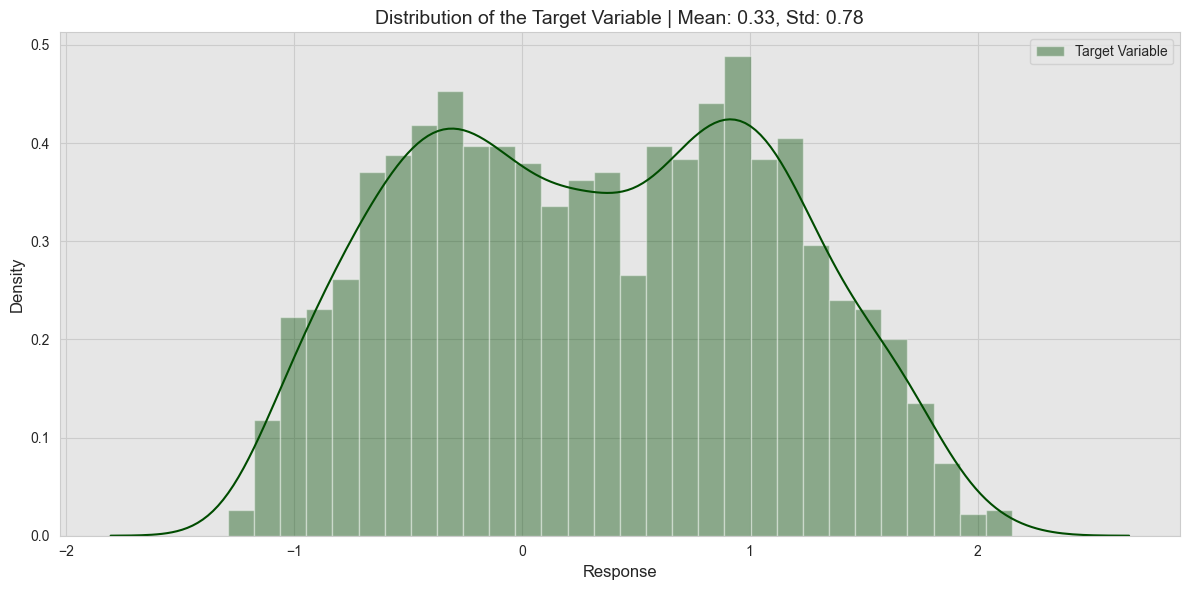

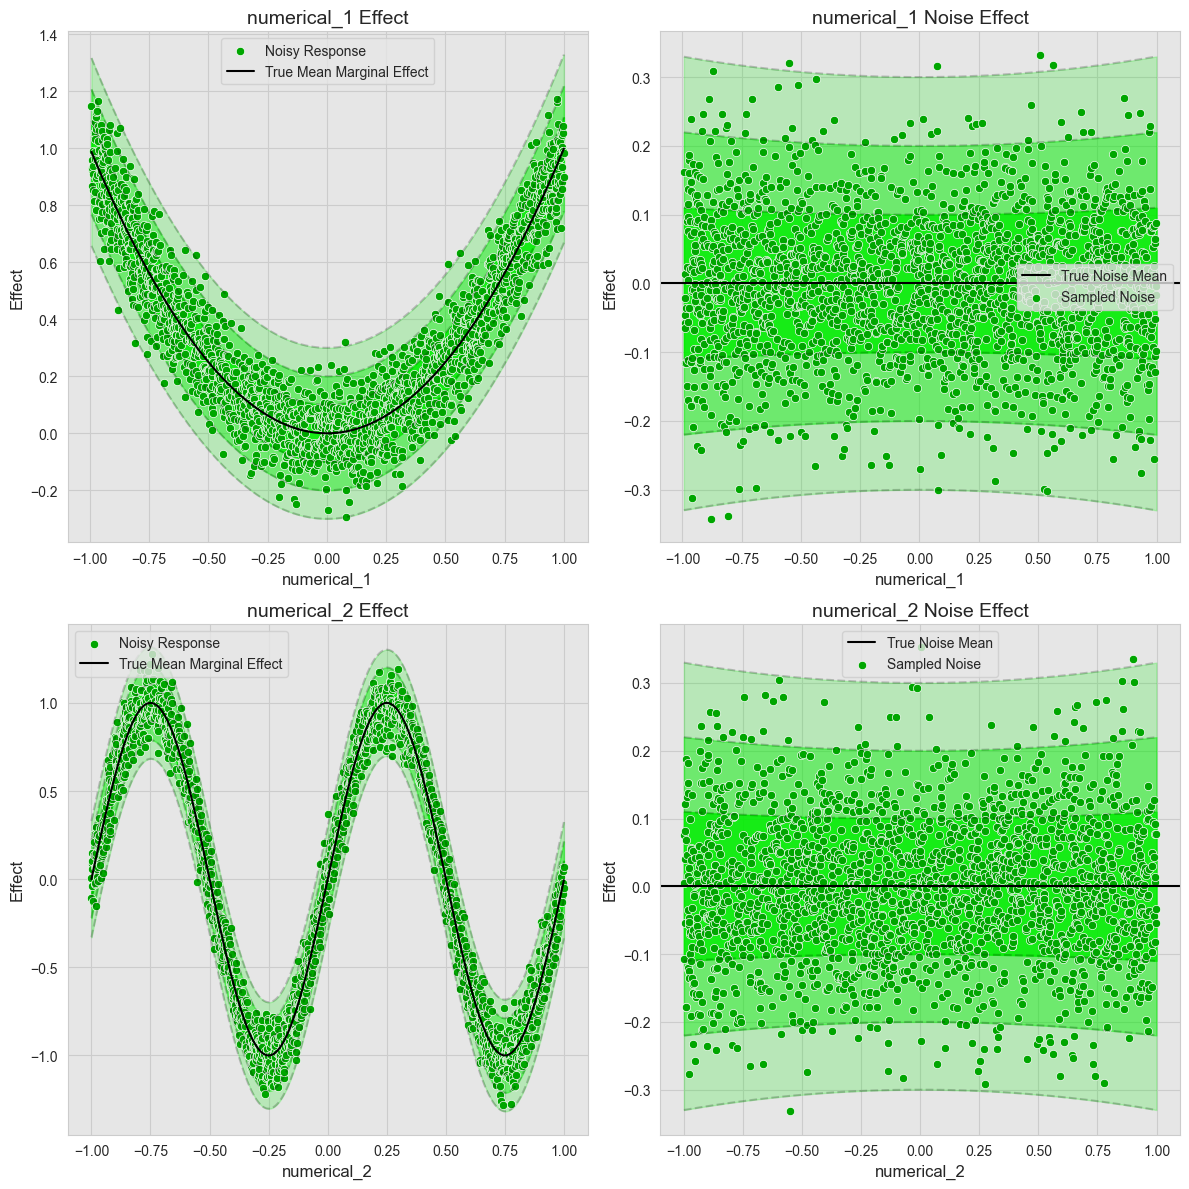

In [6]:
data, _ = get_synthetic_data(n_samples=2000)

In [7]:
X = data.drop(columns=['Response'])
y = data['Response']

input_dim = X.shape[1]

In [8]:
import numpyro
numpyro.set_host_device_count(
    DefaultBayesianNAMConfig().num_chains
)
model = BayesianNAM(
    cat_feature_info={},
    num_feature_info={
        feature_name: {
            "input_dim": 1,
            "output_dim": 2
        } for feature_name in X.columns
    },
    num_classes=1,
    config=DefaultBayesianNAMConfig(),
    subnetwork_config=DefaultBayesianNNConfig()
)

model.train_model(
    num_features={
        feature_name: jnp.array(
            X.iloc[:, col_idx]
        ) for col_idx, feature_name in enumerate(X.columns)
    },
    cat_features={},
    target=jnp.array(y),
)

2025-03-10 08:38:25,113 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-10 08:38:25,123 - namgcv.basemodels.bnn - INFO - Bayesian NN successfully initialized.
2025-03-10 08:38:25,271 - namgcv.basemodels.bnam - INFO - 
+---------------------------------------+
| Bayesian NAM successfully initialized.|
+---------------------------------------+

2025-03-10 08:38:25,271 - namgcv.basemodels.bnam - INFO - Numerical feature network: numerical_1
Network architecture:
Layer 0: Linear(1 -> 16) 
	LayerNorm 
	Activation: tanh 
	Dropout(p=0.1) 
Layer 1: Linear(16 -> 16) 
	LayerNorm 
	Activation: tanh 
	Dropout(p=0.1) 
Layer 2: Linear(16 -> 6) 

2025-03-10 08:38:25,271 - namgcv.basemodels.bnam - INFO - Numerical feature network: numerical_2
Network architecture:
Layer 0: Linear(1 -> 16) 
	LayerNorm 
	Activation: tanh 
	Dropout(p=0.1) 
Layer 1: Linear(16 -> 16) 
	LayerNorm 
	Activation: tanh 
	Dropout(p=0.1) 
Layer 2: Linear(16 -> 6) 

2025-03-10 08:38:26,055 - namgcv.b

TypeError: BayesianNAM.begin_sampling.<locals>.<lambda>() missing 1 required positional argument: 'info'

In [15]:
final_params, final_mixture_coeffs, submodel_contributions = model.predict()
final_loc_1 = final_params[..., 0].mean(axis=0)
final_loc_2 = final_params[..., 1].mean(axis=0)

final_scale_1 = final_params[..., 3].mean(axis=0)
final_scale_2 = final_params[..., 4].mean(axis=0)

final_alpha_1 = final_mixture_coeffs[..., 0].mean(axis=0)
final_alpha_2 = final_mixture_coeffs[..., 1].mean(axis=0)

In [14]:
num_features = model.data_loader.data_test["numerical"]
cat_features = model.data_loader.data_test["categorical"]

In [16]:
interaction_feature_information = {}
all_features = {**num_features, **cat_features}
for interaction_name in submodel_contributions.keys():
    if ":" not in interaction_name:
        continue
    feature_names = interaction_name.split(":")
    interaction_feature_information[interaction_name] = jnp.concatenate(
        [jnp.expand_dims(all_features[name], axis=-1) for name in feature_names],
        axis=-1
    )

0
1
2
3


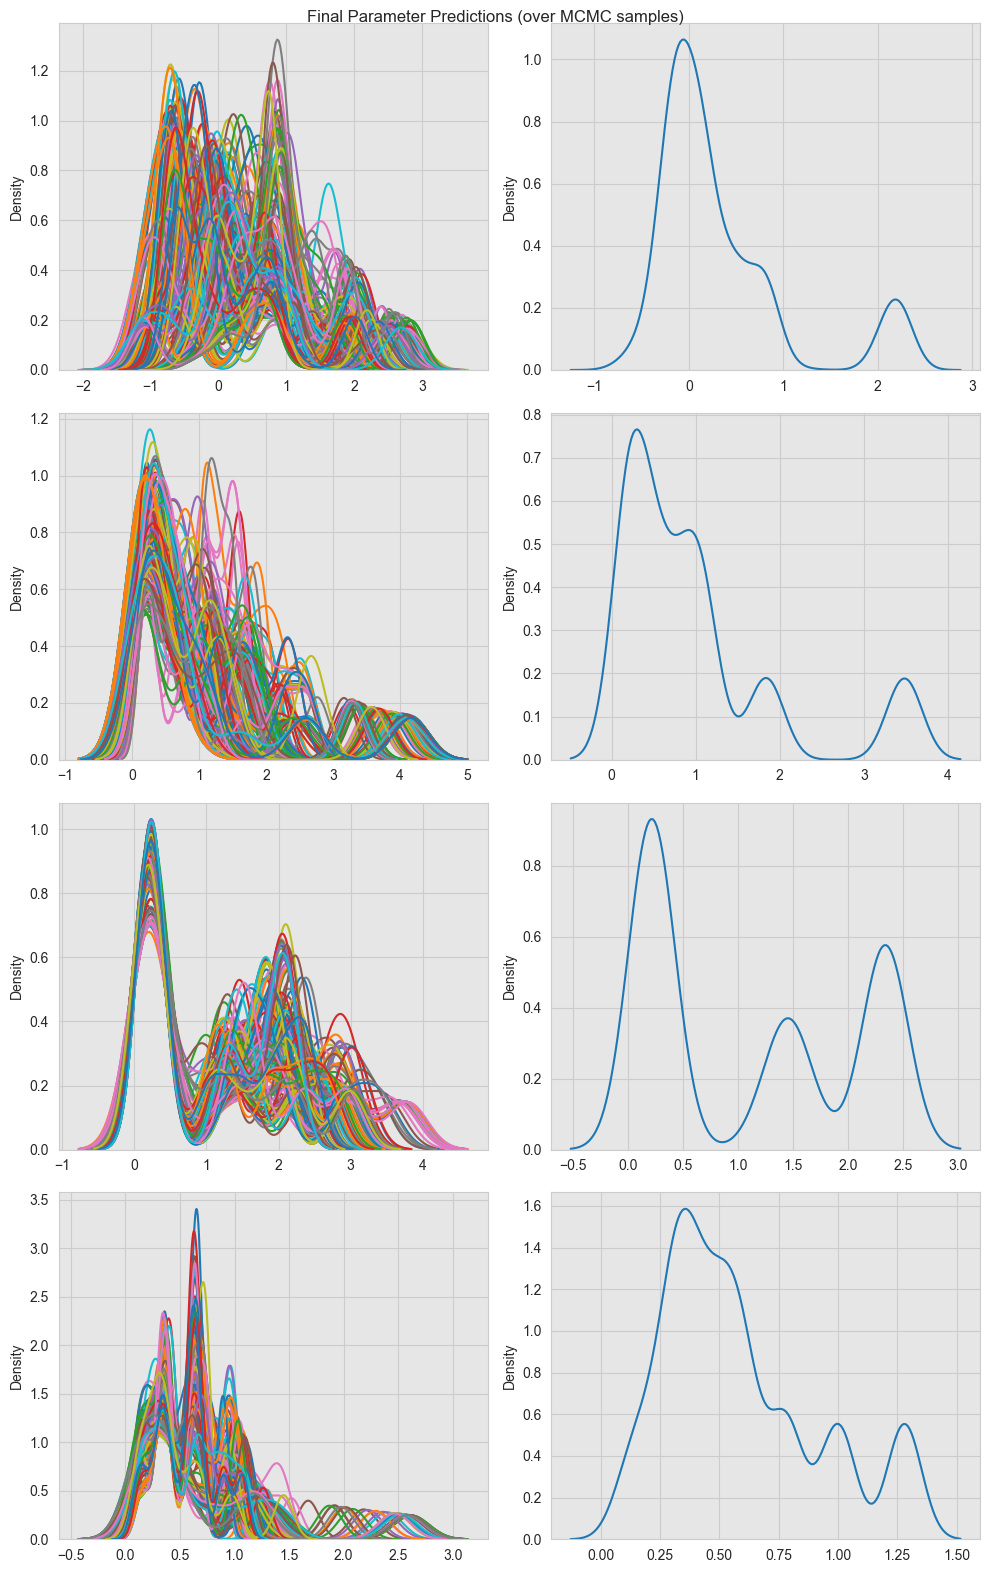

In [42]:
sns.set_style("whitegrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(5*2, 4*4))
for i, (final_param_name, final_param_pred) in enumerate(
        zip(
            ["loc_1", "loc_2", "scale_1", "scale_2",],
            [
                final_params[..., 0],
                final_params[..., 1],
                final_params[..., 2],
                final_params[..., 3],
            ]
        )
):
    for j in range(final_param_pred.shape[1]):
        sns.kdeplot(
            final_param_pred[:, j],
            ax=ax[i, 0]
        )
    sns.kdeplot(
        final_param_pred.mean(axis=1),
        ax=ax[i, 1],
        label=final_param_name
    )
    fig.suptitle(f"Final Parameter Predictions (over MCMC samples)", fontsize=12)
    ax[i, 0].grid(True)
    ax[i, 1].grid(True)

plt.tight_layout()
plt.show()

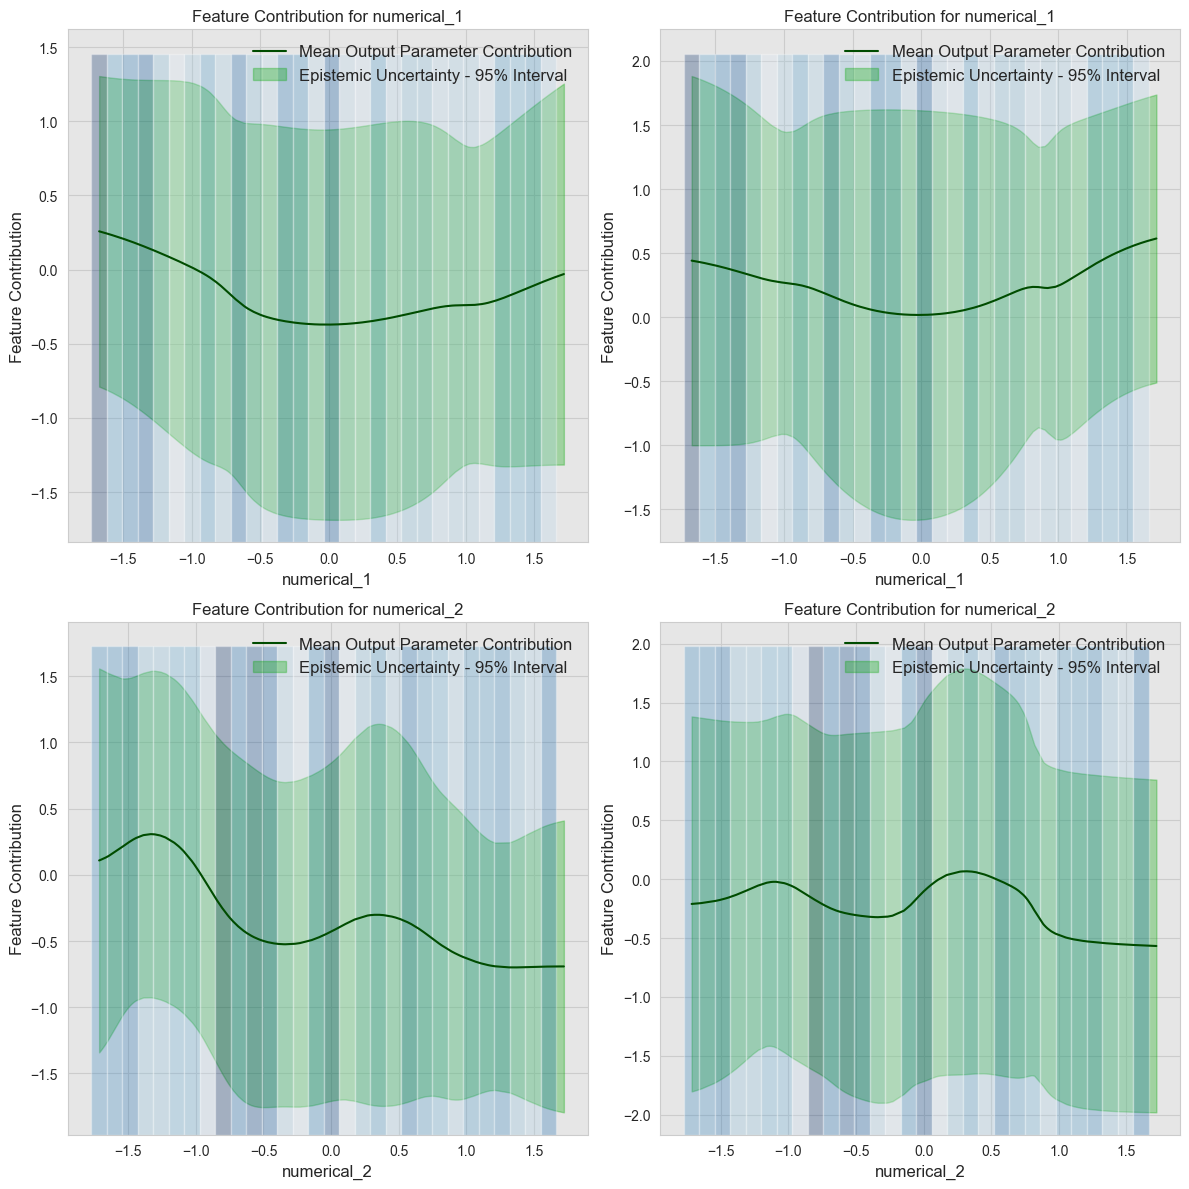

In [24]:
def plot_feature_contributions(
        num_features: dict,
        cat_features: dict,
        interaction_features: dict,
        submodel_contributions: dict,
):
    """
    Plots feature contributions for numerical, categorical, and interaction features.
    Now includes a separate heatmap panel for the uncertainty of interaction features.
    Args:
        num_features (Dict[str, jnp.ndarray]):
            Dictionary of numerical features.
        cat_features (Dict[str, jnp.ndarray]):
            Dictionary of categorical features.
        interaction_features (Dict[str, jnp.ndarray]):
            Dictionary of interaction features.
        submodel_contributions (Dict[str, np.ndarray]):
            Dictionary of feature contributions with keys as feature names and values
            as numpy arrays of shape [num_samples, batch_size].
        target (jnp.ndarray):
            Target variable.
        aleatoric_uncertainty (Dict[str, jnp.ndarray]):
            Dictionary of aleatoric uncertainty estimates for each feature.
    """

    sns.set_style("whitegrid", {"axes.facecolor": ".9"})
    # Plot numerical features
    if num_features:
        num_plots = len(num_features)
        fig, ax = plt.subplots(
            nrows=num_plots, ncols=2,
            figsize=(12, 6 * num_plots),
            squeeze=False
        )
        for i, (feature_name, feature_array) in enumerate(num_features.items()):
            # eu = np.std(np.mean(submodel_contributions[feature_name], axis=1), axis=0)
            # au = np.mean(np.var(submodel_contributions[feature_name], axis=1), axis=0)
            # au = np.mean(aleatoric_uncertainty[f"{feature_name}/{feature_name}_num_subnetwork_sigma"])

            feature_values = np.array(feature_array).flatten()  # Convert JAX array to NumPy

            # Shape: [num_mcmc_samples, batch_size, network_output_dim]
            contributions = submodel_contributions[feature_name]

            # [batch_size, network_output_dim]
            mean_contribution_all_params = contributions.mean(axis=0)
            for j in [0, 1]:
                mean_param_contribution = mean_contribution_all_params[:, j]

                # Create vertical colored bars with color intensity based on density
                sorted_idx = np.argsort(feature_values)
                feature_values_sorted = feature_values[sorted_idx]

                mean_param_contribution_sorted = mean_param_contribution[sorted_idx]

                # if j == 0:
                #     if feature_name == "numerical_1":
                #         true_effect = (feature_values_sorted) ** 2
                #     elif feature_name == "numerical_2":
                #         true_effect =np.exp(feature_values_sorted**3)
                #     elif feature_name == "numerical_3":
                #         true_effect = np.exp((feature_values_sorted) ** 2)
                #     elif feature_name == "numerical_4":
                #         true_effect = np.zeros_like(feature_values_sorted)
                # else:
                #     true_effect = (feature_values_sorted)**2
                #
                # Plot the centered partial contributions.
                sns.lineplot(
                    x=feature_values_sorted,
                    y=mean_param_contribution_sorted,
                    color=GREEN_RGB_COLORS[0],
                    label="Mean Output Parameter Contribution",
                    ax=ax[i, j]
                )
                #
                # # Proper min–max scaling of the true effect onto [lower, upper]
                # lower_sorted, upper_sorted = (mean_param_contribution_sorted.min(),
                #                               mean_param_contribution_sorted.max())
                # te_min, te_max = true_effect.min(), true_effect.max()
                # true_effect_norm = (true_effect - te_min) / (te_max - te_min)  # now in [0,1]
                # true_effect = true_effect_norm * (upper_sorted - lower_sorted) + lower_sorted
                #
                # sns.lineplot(
                #     x=feature_values_sorted,
                #     y=true_effect,
                #     color="black",
                #     linestyle='dashed',
                #     label="True effect",
                #     ax=ax[i,j],
                # )

                uncertainty = np.std(submodel_contributions[feature_name][:, :, j], axis=0)[sorted_idx]
                ax[i,j].fill_between(
                    feature_values_sorted,
                    mean_param_contribution_sorted - 1.96 * uncertainty,
                    mean_param_contribution_sorted + 1.96 * uncertainty,
                    alpha=0.3,
                    color=GREEN_RGB_COLORS[-5],
                    label="Epistemic Uncertainty - 95% Interval"
                )

                num_bins = 30
                counts, bin_edges = np.histogram(feature_values, bins=num_bins)
                norm_counts = counts / counts.max()
                fixed_height = ax[i,j].get_ylim()[1] - ax[i,j].get_ylim()[0]
                for k in range(num_bins):
                    ax[i,j].bar(
                        bin_edges[k],
                        height=fixed_height,
                        bottom=ax[i,j].get_ylim()[0],
                        width=bin_edges[k + 1] - bin_edges[k],
                        color=plt.cm.Blues(norm_counts[k]),
                        alpha=0.3
                    )

                ax[i,j].set_xlabel(f"{feature_name}", fontsize=12)
                ax[i,j].set_ylabel("Feature Contribution", fontsize=12)
                ax[i,j].set_title(f"Feature Contribution for {feature_name}", fontsize=12)
                ax[i,j].legend(loc='best', fontsize=12, frameon=False)
                ax[i,j].grid(True)

        plt.tight_layout()
        plt.savefig('num_feature_contributions.png')
        plt.show()

# -----------------
# Results analysis.
# -----------------
interaction_feature_information = {}
all_features = {**num_features, **cat_features}
for interaction_name in submodel_contributions.keys():
    if ":" not in interaction_name:
        continue

    feature_names = interaction_name.split(":")
    interaction_feature_information[interaction_name] = jnp.concatenate(
        [jnp.expand_dims(all_features[name], axis=-1) for name in feature_names],
        axis=-1
    )

plot_feature_contributions(
    num_features=num_features,
    cat_features=cat_features,
    interaction_features=interaction_feature_information,
    submodel_contributions=submodel_contributions
)


C:\Users\Aleks Lyubenov\AppData\Local\Temp\ipykernel_13532\3382501928.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(


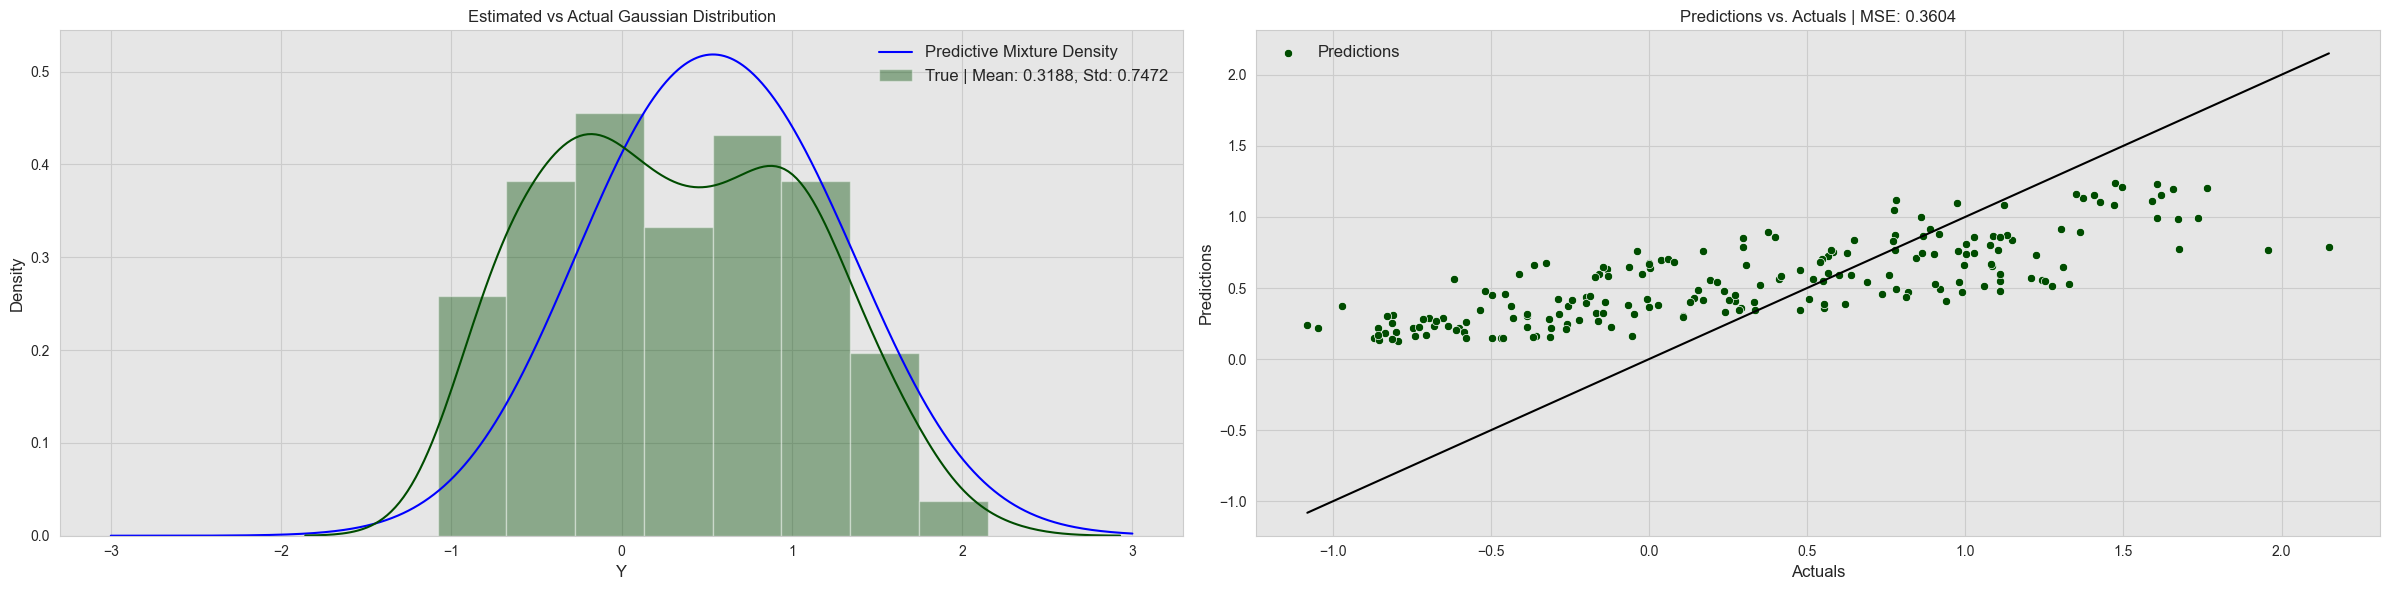

In [44]:
sns.set_style("whitegrid", {"axes.facecolor": ".9"})
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12*2, 6))
x = np.linspace(-3, 3, 1000)
y_test = next(model.data_loader.iter(split="test", batch_size=None))["target"]
N = len(y_test)
density = np.zeros_like(x)
for i in range(N):
    # Mixture density for the i-th prediction:
    density_i = final_alpha_1[i] * norm.pdf(x, final_loc_1[i], final_scale_1[i]) + \
                final_alpha_2[i] * norm.pdf(x, final_loc_2[i], final_scale_2[i])
    density += density_i

density /= N  # Average density

sns.lineplot(x=x, y=density, label="Predictive Mixture Density", color='blue', ax=ax[0])
# Plot the distribution of y_test.
sns.distplot(
    y_test,
    color=GREEN_RGB_COLORS[0],
    label=f"True | "
          f"Mean: {y_test.mean():.4f}, "
          f"Std: {y_test.std():.4f}",
    ax=ax[0],
    hist=True
)
ax[0].set_title("Estimated vs Actual Gaussian Distribution", fontsize=12)
ax[0].set_xlabel("Y", fontsize=12)
ax[0].set_ylabel("Density", fontsize=12)
ax[0].legend(loc='best', fontsize=12, frameon=False)
ax[0].grid(True)

# Plot the predictions vs. actuals.
# Plot the y=x line dotted.
final_loc = final_alpha_1*final_loc_1+final_alpha_2*final_loc_2
sns.lineplot(
    x=y_test,
    y=y_test,
    color="black",
)
sns.scatterplot(
    x=y_test,
    y=final_loc,
    color=GREEN_RGB_COLORS[0],
    label="Predictions",
    ax=ax[1]
)
ax[1].set_xlabel("Actuals", fontsize=12)
ax[1].set_ylabel("Predictions", fontsize=12)
ax[1].set_title(
    f"Predictions vs. Actuals | "
    f"MSE: {np.mean((y_test - final_loc) ** 2):.4f}",
    fontsize=12
)
ax[1].legend(loc='best', fontsize=12, frameon=False)
ax[1].grid(True)

plt.tight_layout()
plt.show()

2025-02-26 15:12:37,829 - namgcv.basemodels.bnam - INFO - All parameter names in the posterior: 
['contrib_numerical_1', 'contrib_numerical_1:numerical_2', 'contrib_numerical_2', 'final_params', 'intercept', 'numerical_1/dense_0_bias', 'numerical_1/dense_0_kernel', 'numerical_1/dense_1_bias', 'numerical_1/dense_1_kernel', 'numerical_1/layer_norm_0_bias', 'numerical_1/layer_norm_0_scale', 'numerical_1:numerical_2/dense_0_bias', 'numerical_1:numerical_2/dense_0_kernel', 'numerical_1:numerical_2/dense_1_bias', 'numerical_1:numerical_2/dense_1_kernel', 'numerical_1:numerical_2/layer_norm_0_bias', 'numerical_1:numerical_2/layer_norm_0_scale', 'numerical_2/dense_0_bias', 'numerical_2/dense_0_kernel', 'numerical_2/dense_1_bias', 'numerical_2/dense_1_kernel', 'numerical_2/layer_norm_0_bias', 'numerical_2/layer_norm_0_scale']
2025-02-26 15:12:37,993 - namgcv.basemodels.bnam - INFO - numerical_1/layer_norm_0_scale: mean=165.145 | std=1733.025


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:38,619 - namgcv.basemodels.bnam - INFO - numerical_1:numerical_2/layer_norm_0_scale: mean=-78.485 | std=2183.463


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:39,369 - namgcv.basemodels.bnam - INFO - numerical_2/layer_norm_0_scale: mean=304.682 | std=1691.430


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


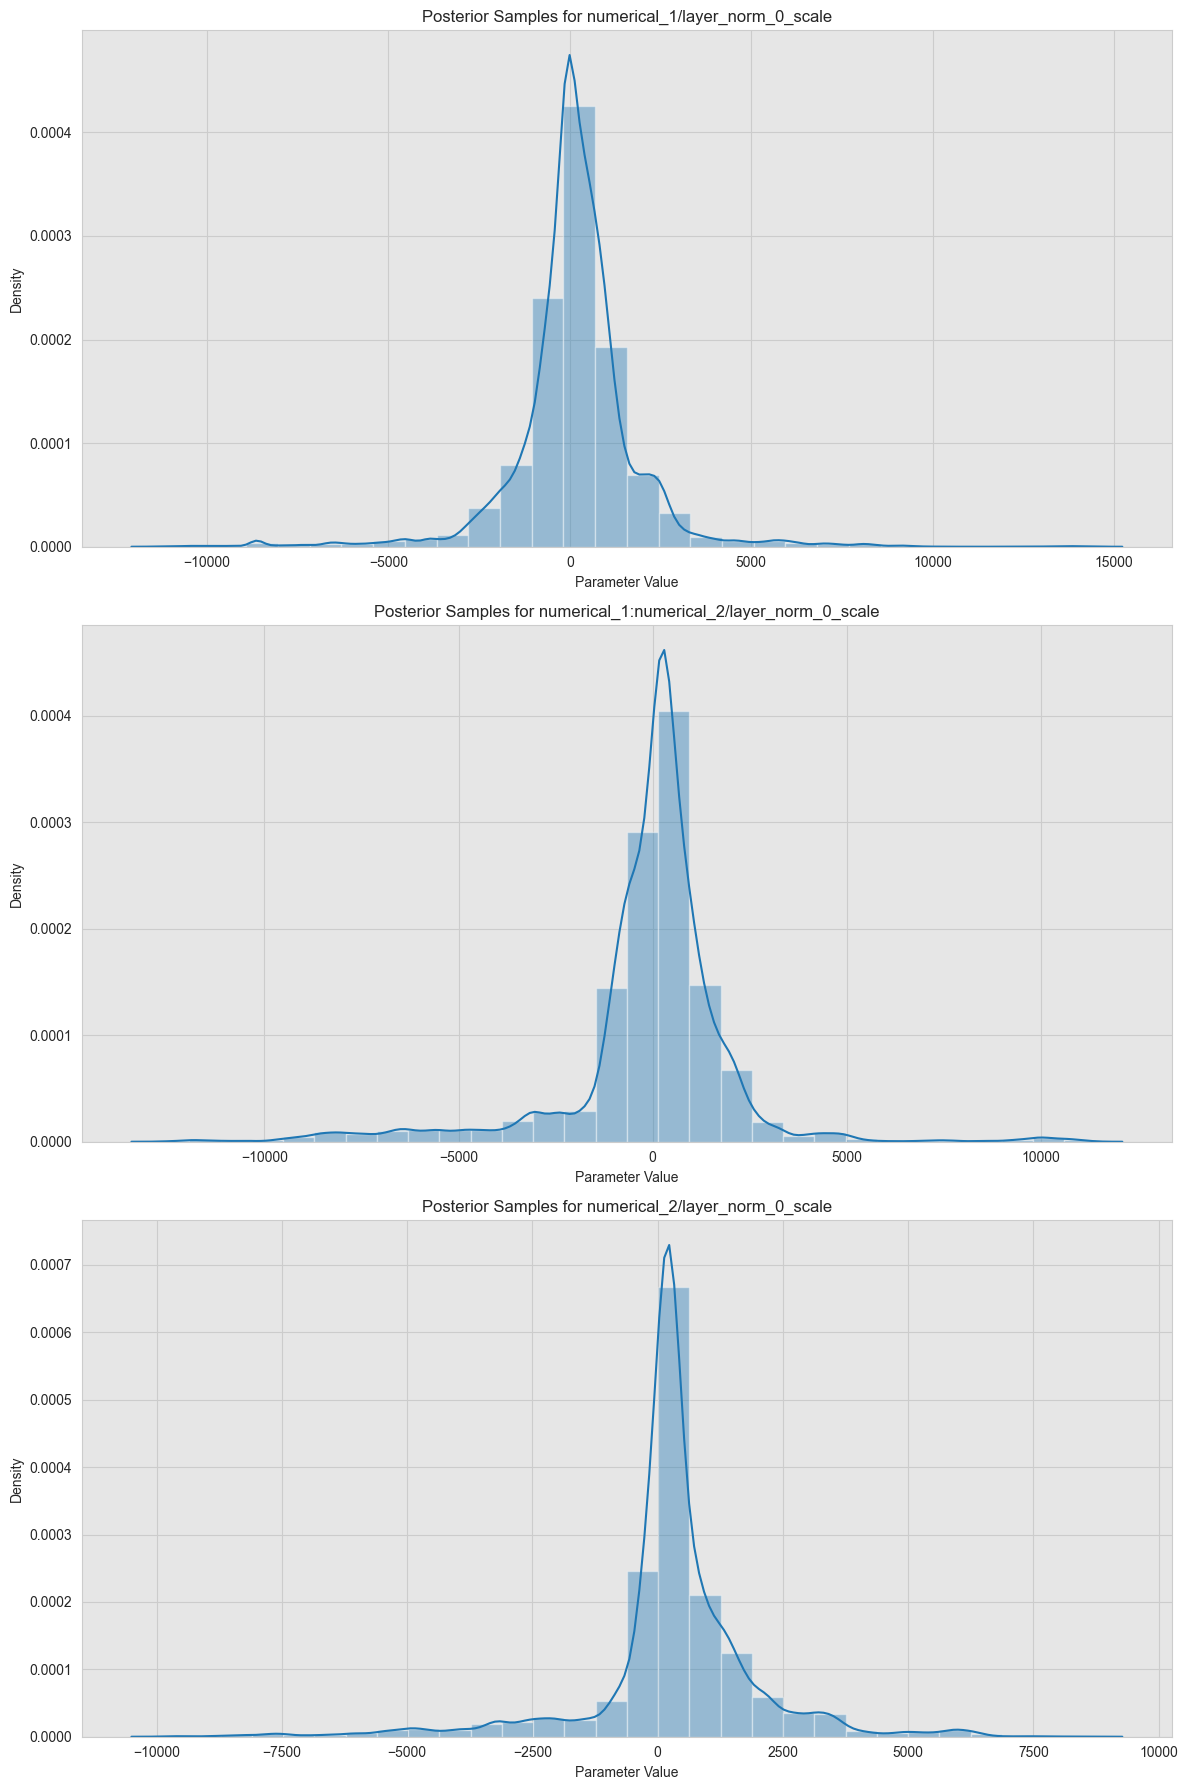

2025-02-26 15:12:40,418 - namgcv.basemodels.bnam - INFO - numerical_1/dense_0_bias: mean=0.004 | std=0.169


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:41,593 - namgcv.basemodels.bnam - INFO - numerical_1/dense_1_bias: mean=0.000 | std=0.182


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:41,920 - namgcv.basemodels.bnam - INFO - numerical_1/layer_norm_0_bias: mean=6.581 | std=1397.267


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:42,731 - namgcv.basemodels.bnam - INFO - numerical_1:numerical_2/dense_0_bias: mean=0.012 | std=0.184


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:43,651 - namgcv.basemodels.bnam - INFO - numerical_1:numerical_2/dense_1_bias: mean=0.017 | std=0.170


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:43,951 - namgcv.basemodels.bnam - INFO - numerical_1:numerical_2/layer_norm_0_bias: mean=-30.962 | std=1442.409


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:44,801 - namgcv.basemodels.bnam - INFO - numerical_2/dense_0_bias: mean=0.010 | std=0.144


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:45,679 - namgcv.basemodels.bnam - INFO - numerical_2/dense_1_bias: mean=0.048 | std=0.186


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


2025-02-26 15:12:45,919 - namgcv.basemodels.bnam - INFO - numerical_2/layer_norm_0_bias: mean=-37.224 | std=1423.938


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


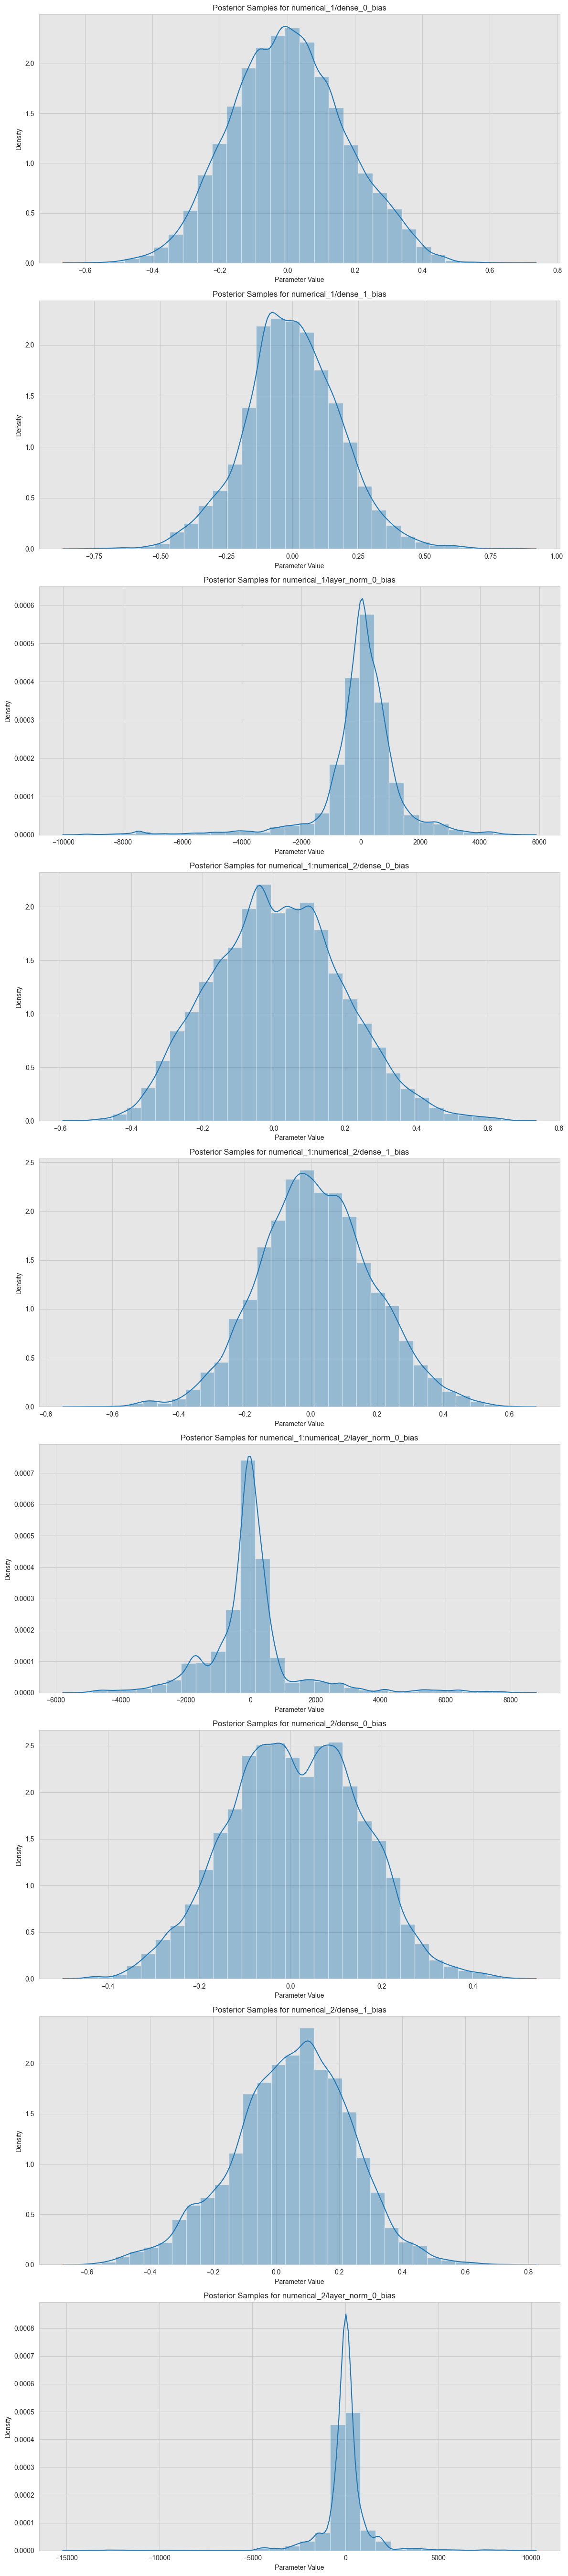

2025-02-26 15:12:47,489 - namgcv.basemodels.bnam - INFO - intercept: mean=0.451 | std=0.850


C:\Users\Aleks Lyubenov\Documents\[LMU] Classes\[5] Winter 2025\Thesis\Repos\NAMgcv\namgcv\basemodels\bnam.py:1147: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  self._logger.info(f"{param_name}: mean={mean_val:.3f} | std={std_val:.3f}")


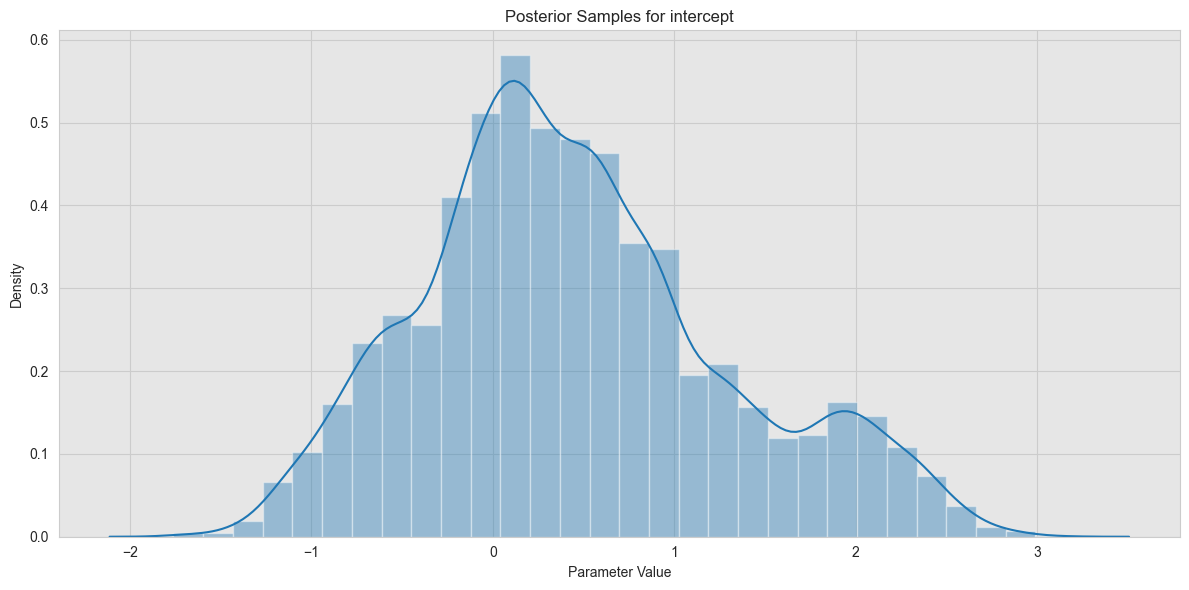

In [14]:
# model.plot_posterior_samples()

2025-02-14 11:47:14,866 INFO:All parameter names in the posterior: 
['contrib_numerical_1', 'contrib_numerical_2', 'final_params', 'intercept', 'numerical_1/numerical_1_num_subnetwork_b0', 'numerical_1/numerical_1_num_subnetwork_b0_scale', 'numerical_1/numerical_1_num_subnetwork_b1', 'numerical_1/numerical_1_num_subnetwork_b1_scale', 'numerical_1/numerical_1_num_subnetwork_b2', 'numerical_1/numerical_1_num_subnetwork_b2_scale', 'numerical_1/numerical_1_num_subnetwork_b3', 'numerical_1/numerical_1_num_subnetwork_b3_scale', 'numerical_1/numerical_1_num_subnetwork_w0', 'numerical_1/numerical_1_num_subnetwork_w0_scale', 'numerical_1/numerical_1_num_subnetwork_w1', 'numerical_1/numerical_1_num_subnetwork_w1_scale', 'numerical_1/numerical_1_num_subnetwork_w2', 'numerical_1/numerical_1_num_subnetwork_w2_scale', 'numerical_1/numerical_1_num_subnetwork_w3', 'numerical_1/numerical_1_num_subnetwork_w3_scale', 'numerical_2/numerical_2_num_subnetwork_b0', 'numerical_2/numerical_2_num_subnetwork_b0_

KeyboardInterrupt: 

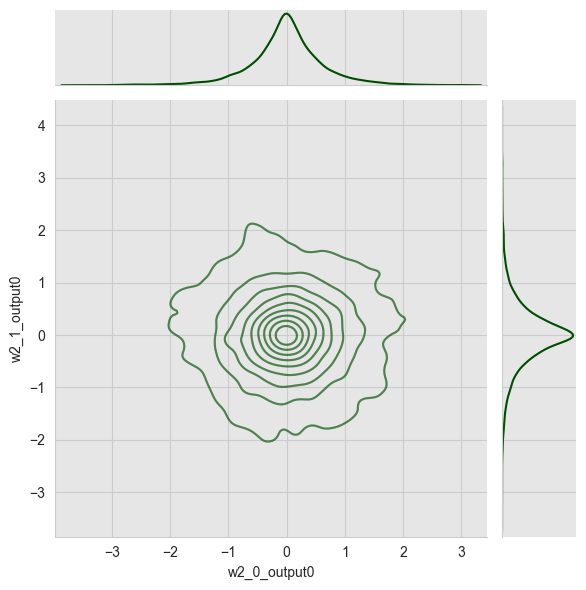

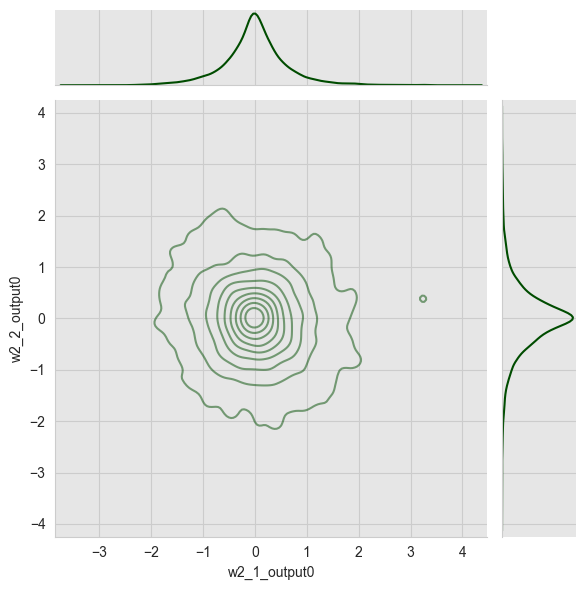

In [13]:
# posterior_param_samples_dict = model._get_posterior_param_samples()
#
# sns.set_style("whitegrid", {"axes.facecolor": ".9"})
# for posterior_params_name, posterior_param_samples in posterior_param_samples_dict.items():
#     if not posterior_param_samples:
#         continue  # Intercept may be None.
#
#     if "weight" not in posterior_params_name:
#         continue  # Only care about weights.
#
#     feature_names = list({
#         key.split("/")[0] for key in posterior_param_samples.keys()
#     })
#     for feature_name in feature_names:
#         param_names = [
#             key for key in posterior_param_samples.keys()
#             if feature_name in key
#         ]  # Parameters for this feature.
#         for i, param_name in enumerate(param_names):
#             if "w2" not in param_name:
#                 continue  # Let's only look at the last layer.
#             if "scale" in param_name:
#                 continue  # Not interested in the hierarchical prior.
#
#             # Convert the posterior samples into a DataFrame for easier plotting.
#             num_samples, num_layer_weights, num_outputs = posterior_param_samples[param_name].shape
#             samples_reshaped = posterior_param_samples[param_name].reshape(
#                 num_samples,
#                 num_layer_weights * num_outputs
#             )
#             column_names = [
#                 f"w2_{i}_output{j}" for j in range(num_outputs) for i in range(num_layer_weights)
#             ]
#             samples_df = pd.DataFrame(samples_reshaped, columns=column_names)
#
#             # Create the plot of bivariate marginals for the last layer weights.
#             for j in range(num_outputs):
#                 for i in range(num_layer_weights - 1):
#                     sns.jointplot(
#                         x=f"w2_{i}_output{j}",
#                         y=f"w2_{i + 1}_output{j}",
#                         data=samples_df,
#                         kind="kde",
#                         alpha=0.5,
#                         color=GREEN_RGB_COLORS[0]
#                     ).plot_joint(sns.kdeplot, color=GREEN_RGB_COLORS[0], alpha=0.3)
#             plt.show()